# Embedded Systems & Control

This notebook is an implementation of the midterm assignment for the *Embedded Systems & Control* course held by [Martina Maggio](https://www.martinamaggio.com/main/) ([Saarland Informatics Campus](https://saarland-informatics-campus.de), [Lund Department of Automatic Control](http://control.lth.se)).

- Given Name: **Aleksa**
- Family Name: **Sukovic**
- ID: **7023848**

The notebook itself was extracted from my course repository, which I cannot share without exposing all of the materials and exercises, which is unfortunately not allowed. Repository associated with this notebook will become available [on my GitHub profile](https://github.com/aleksa-sukovic/esac) after the expiration of the assignment deadline.

In [48]:
import time
import control
import library
import numpy as np

In [49]:
from control.matlab import *
from sympy.matrices import Matrix, eye
from sympy import symbols, solve, simplify, denom, Eq, Poly

In [50]:
%reload_ext autoreload
%autoreload 2

# Velocity Controller

We design a Proportional and Integral (*PI*) controller for the *DC* motor velocity.

## DC Motor Model

First, we define a model of the DC Motor. State matrix $A$ and input matrix $B$ are given in the problem description. The feedthrough matrix $D$ is zero. Finally, since we are designing the velocity controller, our output matrix is set to be $C = \begin{bmatrix} 1 & 0 \end{bmatrix}$.

In [51]:
A = np.array([[-0.12, 0.], [5., 0.]])
B = np.array([[2.25], [0.]])
C = np.array([[1., 0.]])
D = np.array([0.])
S = control.ss(A, B, C, D)

## DC Motor Transfer Function

Next, we define the transfer function of our *DC* Motor (i.e., plant), namely $D(s)$. For this, we use the `control` library, but then manually re-write it using symbolic variables given by `sympy` package. This will allow us to numerically solve for the unknowns of our controller.

In [52]:
control.tf(S)

TransferFunction(array([2.25, 0.  ]), array([1.  , 0.12, 0.  ]))

In [53]:
s = symbols("s")
Ds = (2.25 * s) / (s**2 + 0.12 * s)

## PI Controller

Continuing, we will design our *PI* controller in continuous-time. The *PI* controller is a regular *PID* controller, but with its derivative term set to zero. Thus, it's transfer function is given by the following relation:

$$
\frac{U(s)}{E(s)} = K_p + \frac{1}{s} \cdot K_i
$$

Our task is now to find the controller parameters $K_i$ and $K_p$. To do so, we need to obtain the transfer function of the complete system (i.e., including both, *DC* Motor and the Controller). This is given by the following equation:

$$
G(s) = \frac{C(s) \cdot D(s)}{1 + C(s) \cdot D(s)}
$$

Where $C(s)$ is the transfer function for the controller and $D(s)$ is the transfer function for the *DC* Motor.

In [54]:
Ki, Kp = symbols("Ki Kp")
Cs = Kp + 1/s * Ki

In [55]:
Gs = (Cs * Ds) / (1 + Cs * Ds)

Now we want to find $K_i$ and $K_p$ such that the closed-loop system's (i.e., represented by $G(s)$) poles are set in $-3 \pm 2i$. 

In [56]:
Poles = denom(simplify(Gs))
PolesTarget = Poly((s - complex(-3, +2)) * (s - complex(-3, -2)))

In [57]:
K = solve(Poles - PolesTarget, [Ki, Kp])

In [58]:
print(K)

{Kp: 2.61333333333333, Ki: 5.77777777777778}


Thus, we obtain two portions of our *PI* controller. The final controller transfer function is given by the following relation:

$$
\frac{U(s)}{E(s)} = 2.613+ \frac{1}{s} \cdot 5.778
$$

## Velocity Control Evaluation

We now evaluate our *PI* controller. First, we again fall back to using entities from the `control` library. This allows us to simulate the system's response to a particular input.

In [59]:
Tf = Gs.subs(Ki, K[Ki])
Tf = Tf.subs(Kp, K[Kp])
Tf = simplify(Tf)

After we plug-in the calculated values of our controller, namely $K_i$ and $K_d$, we obtain the simplified transfer function of our complete system, which is given by the following expression:

$$
G(s) = \frac{5.88s + 13.0}{s^2 + 6.0s + 13.0}
$$

We now manually define this transfer function using our `control` library.

In [60]:
Tf = control.tf([5.88, 13.0], [1., 6.0, 13.])
Sys = control.ss(Tf)

### Open-Loop System

To begin the analysis, we plot the unit-step response of our DC Motor, without any control applied.

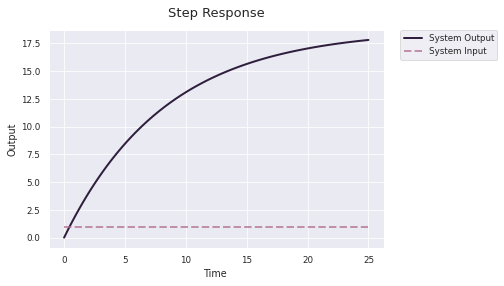

In [61]:
_ = library.step(S)

We can see that the system does go towards some arbitrary point in the neighborhood of $17.5$. With our *PI* controller, for a step-input, we are expecting the system to converge to a static value of $1$.

### PI Control

Next, we plot a unit-step response of the DC Motor, but now with our control applied.

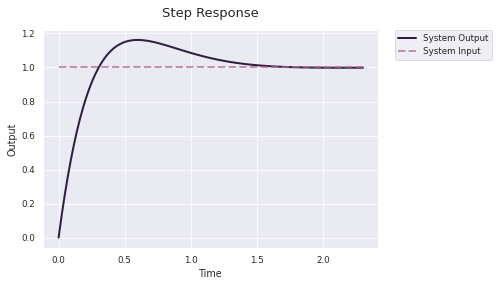

In [62]:
_ = library.step(Sys)

We indeed observe that, given a unit-step input, our system (eventually) converges to a static value of $1$. Finally, to illustrate a slightly more interesting scenario, we simulate the response of our system given a variable set-point input.

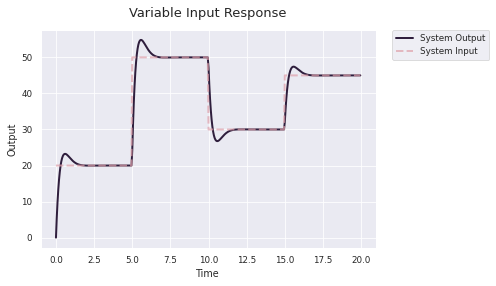

In [63]:
s_input, s_time = library.simulate_inputs([20.0, 50.0, 30.0, 45.0])
_ = library.lsim(Sys, U=s_input, T=s_time)

## PI Control Implementation

To implement the *PI* controller, we are free to write the code in either of the two controller implementation forms, namely *positional* or *incremental*. I've opted to use the **positional** form, as it yields simpler to understand pseudo-code. Since we do not have the derivative term, we actually do not need the to use the derivative approximation techniques mentioned in the lecture (namely, *forward difference*, *backward difference* and *Tustin's approximation*), but just keep track of the integral and proportional quantities. Note that, even tough this is a pseudo-code (i.e., it does not interact with a real plant), it does run and perform all of the required computations (but with hard-coded data).

In [64]:
I = 0.0
period = 1000
y_bar = 20.0 # Wanted system output.

In [65]:
for _ in range(0, 3):
    # 1.) Mark the sampling start time.
    time_start = time.time_ns()
    # 2.) Read the plant output "y" and calculate the error.
    y = 10.0
    error = y_bar - y
    # 3.) Update the controller variables, calculate the control signal.
    I = I + period * error
    u = K[Kp] * error + K[Ki] * I
    # 4.) Apply the control signal to a real plant.
    #     -
    # 5.) Sleep until the next sampling period.
    time_duration = time.time_ns() - time_start
    time.sleep(max(0, period - time_duration))

# Position Control (Observable State)

We now turn our attention to designing a state-feedback control for the DC Motor position. First, we assume our state is measurable and design a regular state-feedback controller. Then, we assume our state is not measurable, use the Luenberg observer to approximate it and, calculate the controller based on the obtained state estimate.

## DC Motor Model

We use the same state model as for the *PI* controller problem. State matrices $A$ and input matrix $B$ are given in the problem description. The feedthrough matrix $D$ is zero. Finally, since we are designing the position controller, our output matrix is set to be $C = \begin{bmatrix} 0 & 1 \end{bmatrix}$.

### Continuous-Time

First, we define the system in continuous-time, as requested by the problem.

In [66]:
A = np.array([[-0.12, 0.], [5., 0.]])
B = np.array([[2.25], [0.]])
C = np.array([[0., 1.]])
D = np.array([0.])
S = control.ss(A, B, C, D)

### Discrete-Time

Next, we discretize the system by sampling it with a sampling period of $\pi = 0.05$.

In [67]:
Pi = 0.05
Sd = control.c2d(S, Pi)
Phi = Sd.A
Gamma = Sd.B

## Controller Poles

Our problem can be reduced to finding the matrices constituting our controller, namely the matrix $K$ and the set-point matrix $S$. First, we want to place the poles of the controller matrix, which is given by $K = \begin{bmatrix} k_1 & k_2 \end{bmatrix}$, to $0.8 \pm 0.1$. To do so, we form the characteristic equation and solve for $K$:

In [68]:
PolesTarget = [complex(0.8, +0.1), complex(0.8, -0.1)]
K = -place(Phi, Gamma, PolesTarget)

## Static Gain

Next, after finding our controller matrix $K$, we incorporate our set-point and find the matrix $S$, by utilizing the final-value theorem and ensuring our transfer function has a static-gain of $1$. After introducing our controller into the state-space model, we obtain the following system:

\begin{align*}
x[k+1] ={} & (\overbrace{\Phi + \Gamma \cdot K}^{A}) \cdot x[k] + \overbrace{\Gamma \cdot S}^{B} \cdot \bar{y}[k] \\[5pt]
y[k] ={} & (\underbrace{C + D \cdot K}_{C}) \cdot x[k] 
\end{align*}

Where the transfer function is obtained using our standard formula:

\begin{align*}
G(z) ={} & C \cdot (z \cdot I - A)^{-1} \cdot B \\
     ={} & (C + DK) \cdot (zI - \Phi - \Gamma K)^{-1} \Gamma S + DS
\end{align*}

Now, considering we have just obtained our $K$, we can solve for $S$, ensuring $G(1)=1$, which implies system's convergence to a given set-point (i.e., system input). We note the usage of the prefix `s` as a variable naming convention, every time a variable is a `sympy` symbolic variable.

In [69]:
sPhi = Matrix(Phi)
sGamma = Matrix(Gamma)
sC = Matrix(C)
sD = Matrix(D)
sK = Matrix(K)
s, z = symbols("s z")

In [70]:
# 1.) Matrix A, from the equation above.
sPhiCL = sPhi + sGamma * sK
# 2.) Matrix B, from the equation above.
sGammaCL = sGamma * Matrix([[s]])
# 3.) Complete transfer function.
Gz = (sC + sD * sK) * (z * eye(2) - sPhiCL).inv() * sGammaCL 

In [71]:
# 1.) Use the final-value theorem.
GLim = Gz.subs(z, 1)
# 2.) Solve for the set-point matrix.
S = solve(Eq(GLim, Matrix([1])), s)[s]

In [72]:
print(f"Controller K: {K}\nController S: {S}")

Controller K: [[-3.28978711 -1.78311644]]
Controller S: 1.78311644444124


Thus, the control signal yielded by our controller is given by:

$$
u[k] = \begin{bmatrix} -3.290 & -1.783 \end{bmatrix} \cdot \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + 1.783 \cdot \bar{y}
$$

## Position Control Evaluation

We now proceed to evaluate the (observable) state-feedback controller.

### Open-Loop System

First, we plot an open-loop system response, without any control applied.

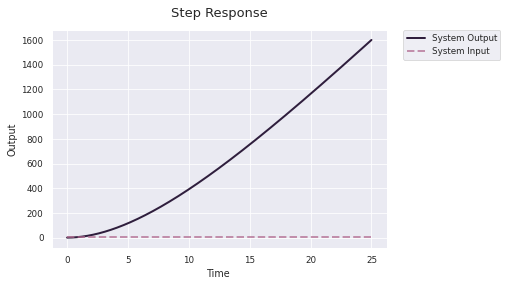

In [73]:
_ = library.step(Sd)

### Feedback-Control System

Next, we incorporate our controller and plot the system response to an input $\bar{y}$. We expect that, after applying the control, our system will (eventually) converge to a static value of $1$.

In [74]:
Sys = control.ss(
    Phi + Gamma * K,
    Gamma * np.array(S),
    C,
    D,
    Pi,
)

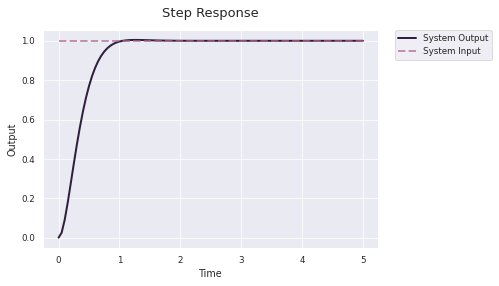

In [75]:
_ = library.step(Sys)

This is, once again, confirmed. Just as before, we simulate the response of our system given a variable set-point input, which is a more realistic situation.

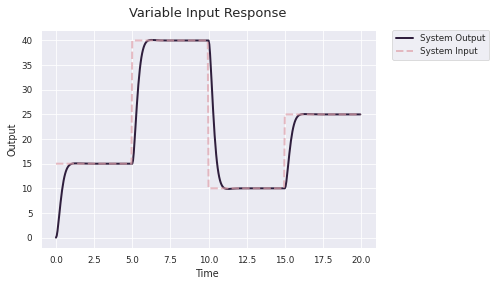

In [76]:
s_input, s_time = library.simulate_inputs([15.0, 40.0, 10.0, 25.0])
_ = library.lsim(Sys, U=s_input, T=s_time)

## Position Control Implementation

The implementation of this state-feedback controller is rather simplistic. Note that, even tough this is a pseudo-code (i.e., it does not interact with a real plant), it does run and perform all of the required computations.

We rely on previously defined matrices $\Phi, \Gamma, C, D$. We also define the system output matrix $y$ and our wanted target matrix $\bar{y}$. Our controller ensures the system output $y$ converges towards the wanted system output $\bar{y}$. In addition, we define a matrix $x$ representing our (observable) state as well as a matrix $u$ representing our control signal, as calculated by the controller.

In [77]:
period = 1000
y      = np.zeros((1, 1))
y_bar  = np.zeros((1, 1))
x      = np.zeros((2, 1))
u      = np.zeros((1, 1))

Next, we define our controller matrix $K$ as well as the set-point matrix $S$. We simply use the values calculated above.

In [78]:
K = np.array([[-3.290, -1.783]])
S = np.array([[1.783]])

Finally, we define our control loop. In a real world, this would be intrinsically tied to the system's lifecycle (i.e., while system is powered on, perform control). Here, we just run couple of iterations, enough to illustrate the correctness of calculations.

In [79]:
for _ in range(0, 3):
    # 1.) Mark the sampling start time.
    time_start = time.time_ns()
    # 2.) * System output. Read from plant.
    y[0][0] = 1.0         
    # 3.) * Target value. Read from user.
    y_bar[0][0] = 2.0     
    # 4.) Calculate the control signal. This is plant's input.
    u = K @ x + S @ y_bar 
    # 5.) Apply the control signal to a real plan.
    #     -
    # 6.) Sleep until the next sampling period.
    time_duration = time.time_ns() - time_start
    time.sleep(max(0, period - time_duration))

# Position Control (Non-Observable State)

Finally, we design a state-feedback control for the DC Motor position, only this time assuming we **cannot** measure the system state.

## DC Motor Model

The plant model is identical to the one described in problem (2). State matrix $A$ and input matrix $B$ are given in the problem description. The feedthrough matrix $D$ is zero and $C = \begin{bmatrix} 0 & 1 \end{bmatrix}$.

### Continuous-Time

Like before, we first define the continuous-time system.

In [80]:
A = np.array([[-0.12, 0.], [5., 0.]])
B = np.array([[2.25], [0.]])
C = np.array([[0., 1.]])
D = np.array([0.])
S = control.ss(A, B, C, D)

### Discrete-Time

Next, we discretize the system by sampling it with a sampling period of $\pi = 0.05$.

In [81]:
Pi = 0.05
Sd = control.c2d(S, Pi)
Phi = Sd.A
Gamma = Sd.B

## Obtaining Controller

With or without observer, we obtain the controller parameter matrices $K$ and $S$ in a same manner.

### Controller Poles

Similar to before, we first set the controller poles by solving for the eigenvalues of the $\Phi_{CL}$ matrix.

In [82]:
PolesCL = [complex(0.8, +0.1), complex(0.8, -0.1)]
K = -place(Phi, Gamma, PolesCL)

### Set-Point Tracking

To ensure our system converges to a given set-point, we again utilize the final-value theorem and solve for the static-gain of a system to be equal to $1$.

In [83]:
sPhi = Matrix(Phi)
sGamma = Matrix(Gamma)
sC = Matrix(C)
sD = Matrix(D)
sK = Matrix(K)
s, z = symbols("s z")

In [84]:
sPhiCL = sPhi + sGamma * sK
sGammaCL = sGamma * s
Gz = (sC + sD * sK) * (z * eye(2) - sPhiCL).inv() * sGammaCL

In [85]:
GLim = Gz.subs(z, 1)
sS = solve(Eq(GLim, Matrix([1])), s)[s]
S = np.array(sS)

The control signal yielded by our controller is now given by the following equation:
$$
u[k] = \begin{bmatrix} -3.290 & -1.783 \end{bmatrix} \cdot \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} + 1.783 \cdot \bar{y}
$$

## Obtaining Observer

This is a point where we diverge from task (2). Namely, we can no longer assume our state $x[k]$ is measurable. Thus, we approximate it by $\hat{x}[k]$, given by our observer. More specifically, we will use the [Luenberger Observer](https://en.wikipedia.org/wiki/State_observer), which approximates a state by the following quantity:

$$
\hat{x}[k+1] = \Phi \cdot \hat{x}[k] + \Gamma \cdot u[k] + L \cdot (y[k] - C \cdot \hat{x}[k])
$$

We now proceed to find $L=\begin{bmatrix} l_1 & l_2 \end{bmatrix}^T$. Similar as with the $K$ matrix of our controller, we do this by setting the eigenvalues of the observer matrix:

$$
\Phi_{OB} = \Phi - L \cdot C
$$

In [86]:
PolesOB = [complex(0.6, +0.2), complex(0.6, -0.2)]
L = place(Phi.T, C.T, PolesOB).T

Thus, we obtain $L = \begin{bmatrix} 0.783 & 0.794 \end{bmatrix}^T$.

## Controller Evaluation

To evaluate this controller, we must create a dynamical system that incorporates both, the controller defined by $K$ and $S$, but also our observer defined by $L$. Without trying to derive the relation, we show the system dynamics:

\begin{align*}
\tilde{x}[k+1] ={} & \overbrace{\begin{bmatrix} \Phi & \Gamma K \\ L C & \Phi - LC + \Gamma K \end{bmatrix}}^{\Phi_o} \cdot \tilde{x}[k] + \overbrace{\begin{bmatrix}\Gamma S \\ \Gamma S \end{bmatrix}}^{\Gamma_o} \cdot \bar{y}[k] \\[20pt]
y[k] ={} & \underbrace{\begin{bmatrix} C & DK \end{bmatrix}}_{C_o} \cdot \tilde{x}[k] + \underbrace{\begin{bmatrix} DS \end{bmatrix}}_{D_o} \cdot \bar{y}[k]
\end{align*}

In [87]:
PhiO = np.block([[Phi, Gamma * K], [L * C, Phi - L * C + Gamma * K]])
GammaO = np.block([[Gamma * S], [Gamma * S]])
CO = np.block([[C, D * K]])
DO = np.block([[D * S]])
SO = ss(PhiO, GammaO, CO, DO, Pi)

Upon defining a system, like before, we run a basic analysis by applying a unit-step and observing the response.

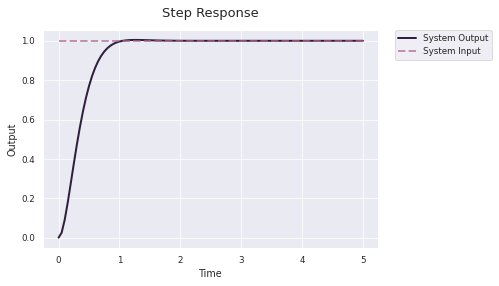

In [88]:
_ = library.step(SO)

Finally, we simulate the response of our system given a variable set-point input:

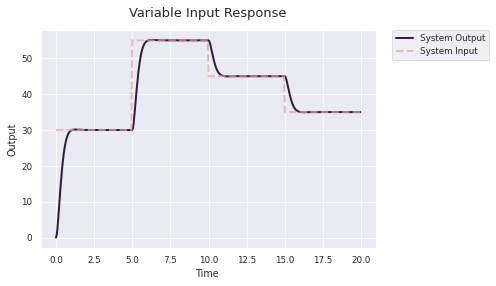

In [89]:
s_input, s_time = library.simulate_inputs([30.0, 55.0, 45.0, 35.0])
_ = library.lsim(Sys, U=s_input, T=s_time)

## Non-Observable Position Control Implementation

The implementation of this state-feedback controller with a Luenberg observer leans on our previous implementation. Note that, even tough this is a pseudo-code (i.e., it does not interact with a real plant), it does run and perform all of the required computations.

We rely on previously defined matrices $\Phi, \Gamma, C, D$. We also define the system output matrix $y$ and our wanted target matrix $\bar{y}$. Our controller ensures the system output $y$ converges towards the wanted system output $\bar{y}$. In addition, we also define a matrix $\hat{x}$ representing our (now estimated) state as well as matrix $u$ representing our control signal calculated by the controller.

In [90]:
y     = np.zeros((1, 1))
y_bar = np.zeros((1, 1))
x_hat = np.zeros((2, 1))
u     = np.zeros((1, 1))

In [91]:
K = np.array([[-3.290, -1.783]])
S = np.array([[1.783]])
L = np.array([[0.783], [0.794]])

In [92]:
for _ in range(0, 3):
    # 1.) Mark the sampling start time.
    time_start = time.time_ns()
    # 2.) * System output. Read from plant, using calculated input u.
    y[0][0] = 1.0                                         
    # 3.) * Target value. Read from user.
    y_bar[0][0] = 2.0                                     
    # 4.) Calculate the state estimate.
    x_hat = Phi @ x_hat + Gamma @ u + L @ (y - C @ x_hat) 
    # 5.) Calculate the control signal. This is plant's input.
    u = K @ x_hat + S @ y_bar                             
    # 6.) Apply the control signal to a real plan.
    #     -
    # 7.) Sleep until the next sampling period.
    time_duration = time.time_ns() - time_start
    time.sleep(max(0, period - time_duration))